# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [98]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [99]:
#print(model)
model = HANKModelClass(name='baseline')
#model.print_unpack_varlist()

# Step 1: Steady state

In [100]:
model.find_ss(do_print=True)

steady state found in 22.8 secs
 Q   =   0.6682
 P   =   0.7812
 Z_N   =   0.2334
 Z_L   =   1.0870
 M_N   =   0.3150
 M_L   =   0.1242
 N_L   =   0.3698
 N_N   =   0.5844
 HH_ell   =   1.1376
 wage N  =   0.2774
 wage L  =   0.4152
 par.varphi   =   1.0000
 par.beta   =   0.9712
Discrepancy in B =   0.00000000
Discrepancy in C =   0.00000000
Discrepancy in C_L =   0.00000000
Discrepancy in C_N =   0.00000000
Discrepancy in N =   0.00000000


In [101]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

Distribution graphs:

Average expenditures share on luxuries (in the data = 51.8%) =   0.5148
Average expenditures share on luxuries for the lowest income households (in the data = 29.5%): =   0.2841
Average expenditures share on necessities (in the data = 48.2%) =   0.4852
Average expenditures share on necessities, net of subsistence (in the data = 35.1%) =   0.3827


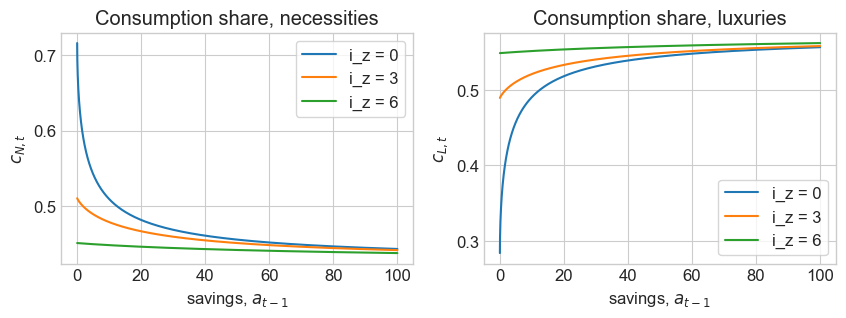

In [103]:
fig = plt.figure(figsize=(10,3),dpi=100)
a_max = 500

# a. necessity consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(1,2,1)
ax.set_title(f'Consumption share, necessities')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c_N[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{N,t}$')

# a. luxury consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(1,2,2)
ax.set_title(f'Consumption share, luxuries')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.Q*ss.c_L[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{L,t}$')

print(f'Average expenditures share on luxuries (in the data = 51.8%) = {(ss.C_L*ss.Q/(ss.P*ss.C)):8.4f}')
print(f'Average expenditures share on luxuries for the lowest income households (in the data = 29.5%): = {(ss.Q*np.average(ss.c_L[0,0,0]))/(ss.P*np.average(ss.c[0,0,0])):8.4f}')
print(f'Average expenditures share on necessities (in the data = 48.2%) = {(ss.C_N/(ss.P*ss.C)):8.4f}')
print(f'Average expenditures share on necessities, net of subsistence (in the data = 35.1%) = {(ss.C_HAT_N_hh/(ss.P*ss.C)):8.4f}')

Marginal propensities to consume

mean MPC: 0.074 [annual: 0.264]


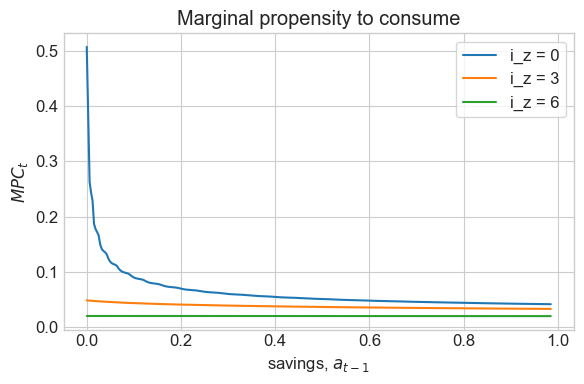

In [111]:
MPC = np.zeros(ss.D.shape)
m_diff = (1+ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = (ss.c[:,:,1:]-ss.c[:,:,:-1])/m_diff
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

fig = plt.figure(figsize=(6,4),dpi=100)

# c. MPC
I = par.a_grid < 1

ax = fig.add_subplot(1,1,1)
ax.set_title(f'Marginal propensity to consume')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],MPC[0,i_z,I],label=f'i_z = {i_z}')
ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$MPC_{t}$')

fig.tight_layout()

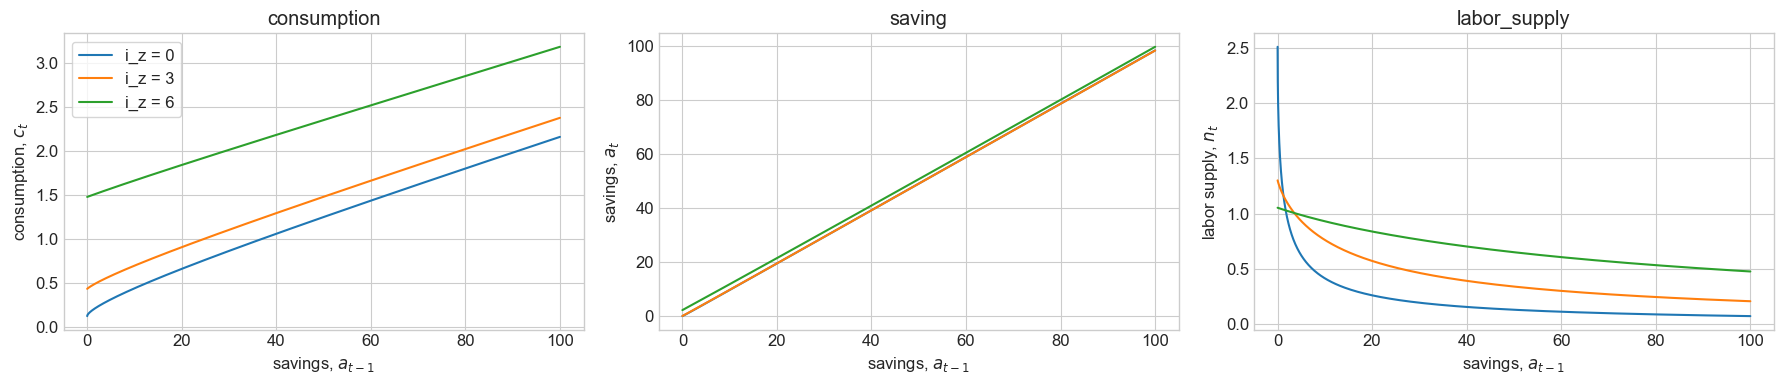

In [105]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.5 secs
household problem simulated along transition in 2.2 secs



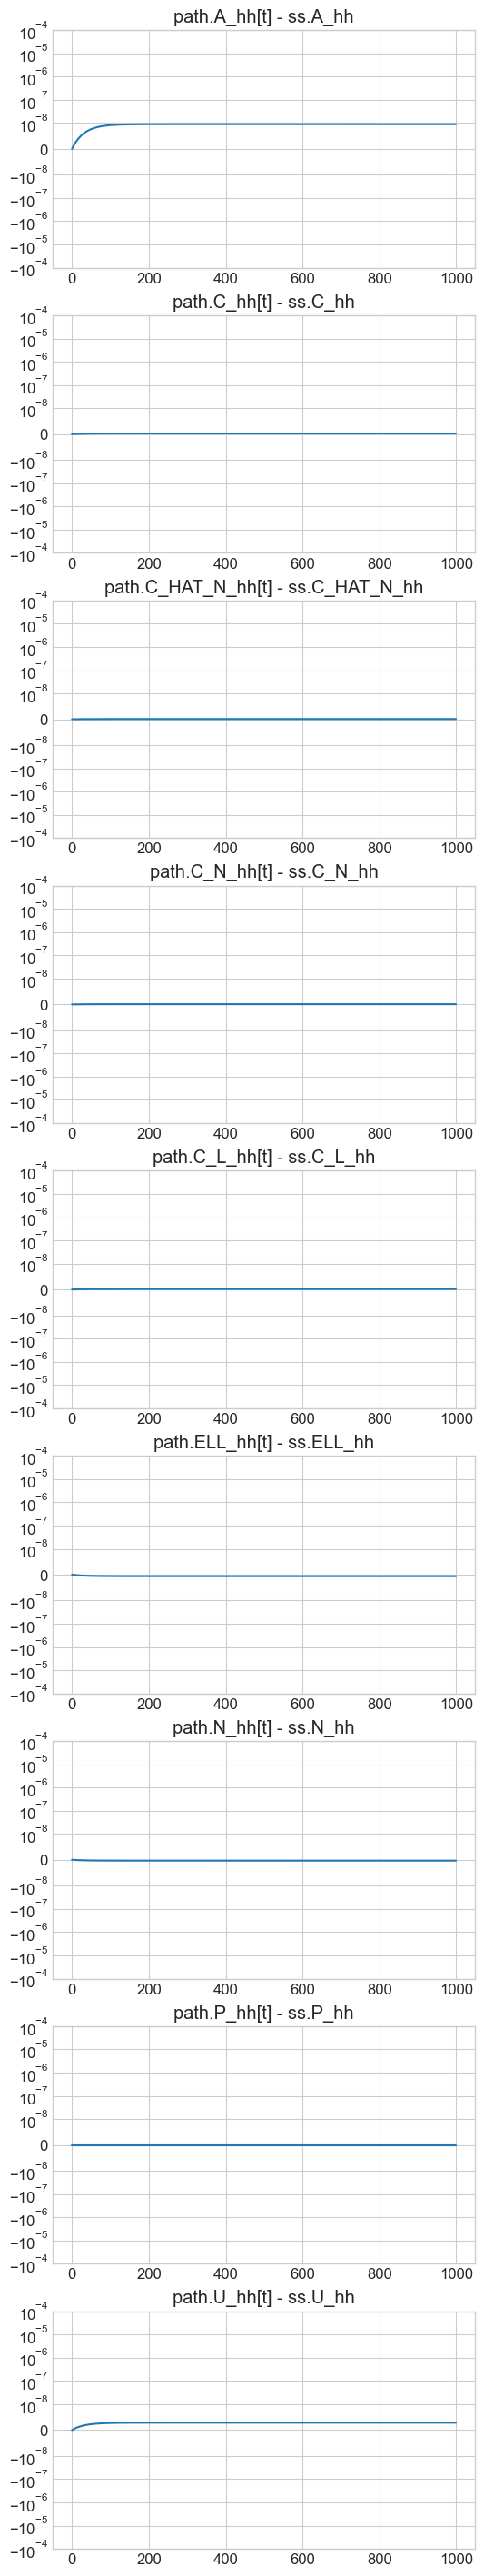

In [106]:
model.test_hh_path()

**Full transition path:**

In [107]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  0.0e+00
C_N            : t0 =  0.0e+00, max abs.  0.0e+00
C_L            : t0 =  0.0e+00, max abs.  0.0e+00
d_N            : t0 =  0.0e+00, max abs.  0.0e+00
d_L            : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 = -6.9e-18, max abs.  6.9e-18
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
N_N            : t0 =  0.0e+00, max abs.  0.0e+00
N_L            : t0 =  0.0e+00, max abs.  0.0e+00
M_N            : t0 =  0.0e+00, max abs.  0.0e+00
M_L            : t0 =  0.0e+00, max abs.  0.0e+00
pm_L           : t0 =  0.0e+00, max abs.  0.0e+00
pm_N           : t0 =  0.0e+00, max abs.  0.0e+00
pi             : t0 =  0.0e+00, max abs.  0.0e+00
pi_N           : t0

In [108]:
model.compute_jacs(do_print=True)
#model.test_jacs(s_list=[50,100,150])

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for P               in 1.9 secs
curly_Y and curly_D calculated for Q               in 2.1 secs
curly_Y and curly_D calculated for d_L             in 2.0 secs
curly_Y and curly_D calculated for d_N             in 1.9 secs
curly_Y and curly_D calculated for r               in 1.9 secs
curly_Y and curly_D calculated for tau             in 1.9 secs
curly_Y and curly_D calculated for w_N             in 2.0 secs
curly_E calculated in 0.4 secs
builiding blocks combined in 2.5 secs
household Jacobian computed in 16.6 secs

full Jacobians:
full Jacobian to unknowns computed in 31.9 secs [in evaluate_path(): 13.0 secs]
full Jacobian to shocks computed in 29.5 secs [in evaluate_path(): 21.0 secs]


# Step 3a: Find non-linear transition path

## Find transition path

In [109]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 2.79e-02
   3.52e-03 in NKPC_res_N
   3.71e-04 in NKPC_res_L
   2.79e-02 in clearing_A
   2.05e-03 in clearing_N
   2.93e-03 in clearing_C_N
 it =   1 -> max. abs. error = 6.03e-04
   1.53e-05 in NKPC_res_N
   3.32e-06 in NKPC_res_L
   6.03e-04 in clearing_A
   5.77e-05 in clearing_N
   9.61e-05 in clearing_C_N
 it =   2 -> max. abs. error = 1.02e-05
   3.55e-07 in NKPC_res_N
   3.20e-07 in NKPC_res_L
   1.02e-05 in clearing_A
   5.98e-06 in clearing_N
   3.23e-06 in clearing_C_N
 it =   3 -> max. abs. error = 1.82e-07
   1.38e-08 in NKPC_res_N
   5.66e-09 in NKPC_res_L
   1.82e-07 in clearing_A
   9.80e-08 in clearing_N
   2.05e-08 in clearing_C_N
 it =   4 -> max. abs. error = 3.38e-09
   4.84e-10 in NKPC_res_N
   2.05e-10 in NKPC_res_L
   3.27e-09 in clearing_A
   3.38e-09 in clearing_N
   4.97e-10 in clearing_C_N
 it =   5 -> max. abs. error = 1.06e-10
   1.50e-11 in NKPC_res_N
   3.92e-12 in NKPC_res_L
   2.74e-11 in clea

## Plot transitions

### shocks ###


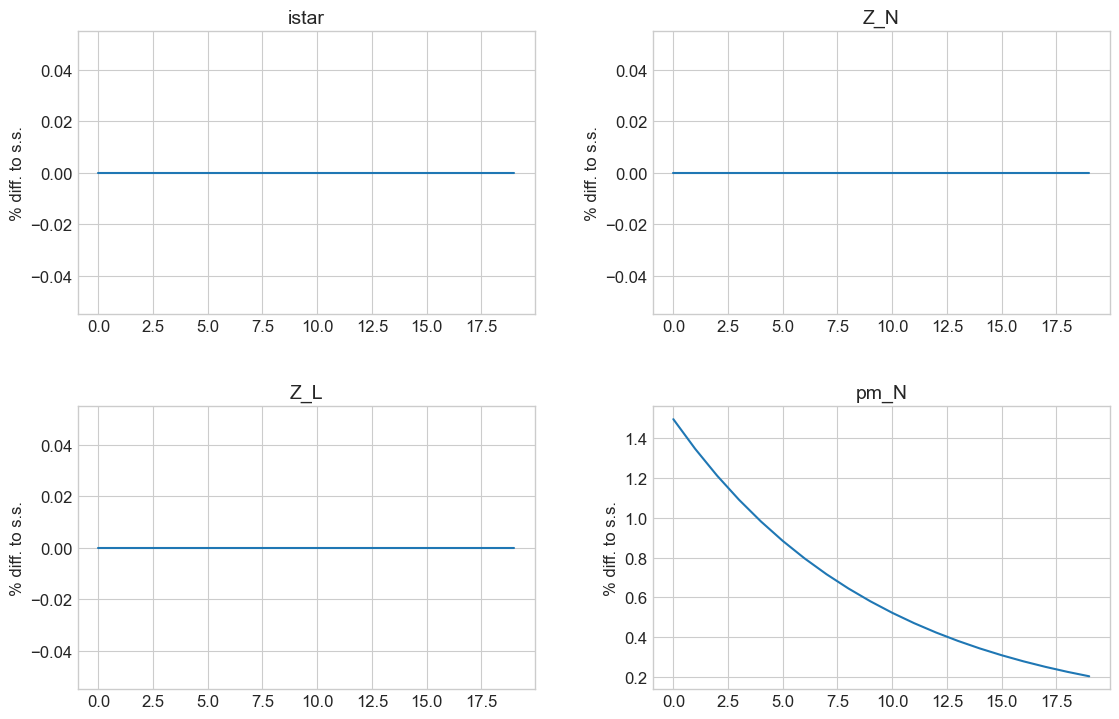


### varnames ###


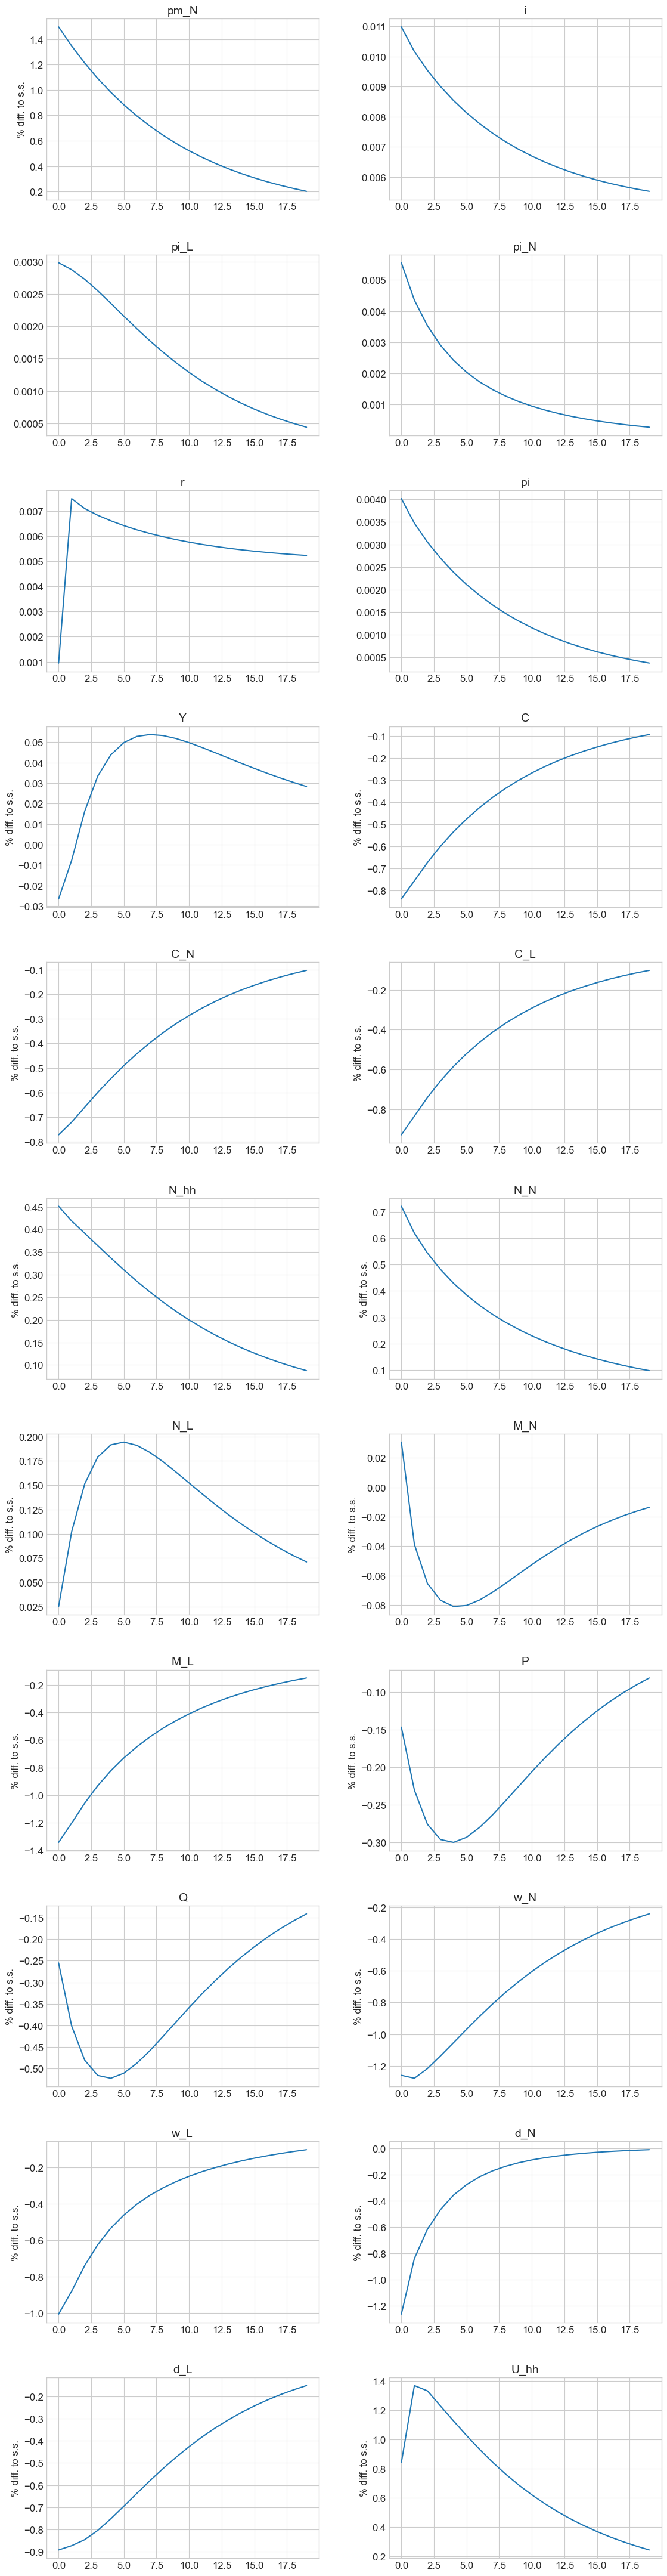


### tagets ###


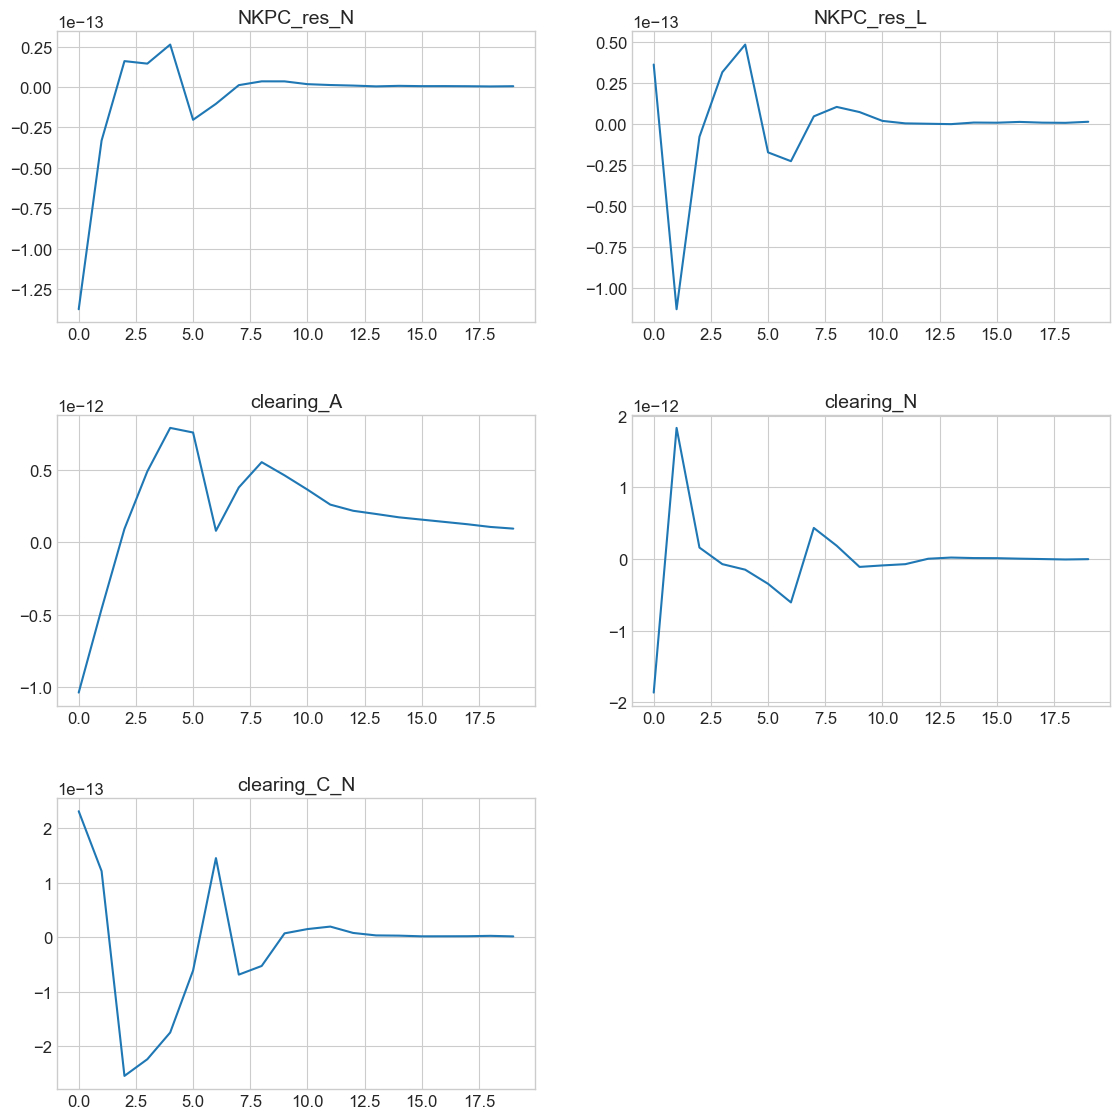

In [110]:
paths = ['pm_N','i','pi_L','pi_N','r','pi','Y','C','C_N','C_L','N_hh','N_N','N_L','M_N','M_L','P','Q','w_N','w_L','d_N','d_L','U_hh']
lvl_value = ['i','pi_L','pi_N','r','pi']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=2)


Behavior for a subset of households. Here those with zero assets.

['w_N']
household problem solved along transition path in 1.5 secs
household problem simulated along transition in 0.2 secs

['r']
household problem solved along transition path in 1.4 secs
household problem simulated along transition in 0.2 secs

['d_N']
household problem solved along transition path in 1.3 secs
household problem simulated along transition in 0.2 secs

['d_L']
household problem solved along transition path in 1.2 secs
household problem simulated along transition in 0.2 secs

['tau']
household problem solved along transition path in 1.2 secs
household problem simulated along transition in 0.2 secs

['P']
household problem solved along transition path in 1.3 secs
household problem simulated along transition in 0.2 secs

['Q']
household problem solved along transition path in 1.2 secs
household problem simulated along transition in 0.2 secs

None
household problem solved along transition path in 1.2 secs
household problem simulated along transition in 0.2 secs

all
house

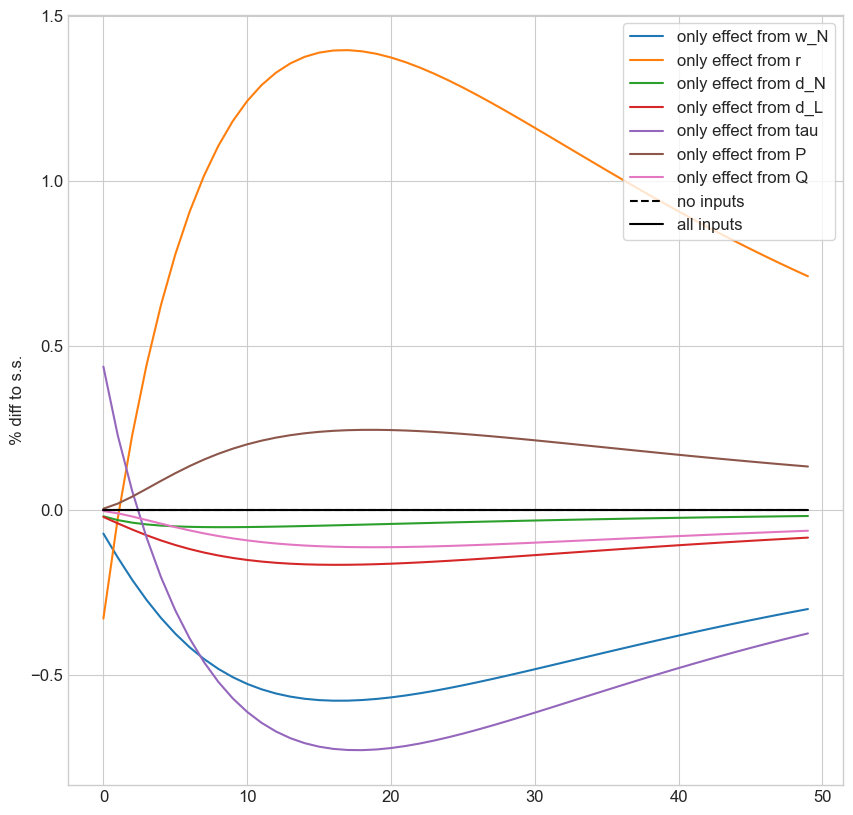

In [112]:
T_max = 50

fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['w_N'],['r'],['d_N'],['d_L'],['tau'],['P'],['Q'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[0,:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

In [ ]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
#Dbeg[:,1:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg[:,:5,:450] = 0.0 # zero every else than in last 50 asset grid points
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response in ss')
ax.plot(path_alt_ss.U_hh[0,:50]);

ax = fig.add_subplot(1,3,2)
ax.set_title('response in path')
ax.plot(path_alt.U_hh[0,:50]);

ax = fig.add_subplot(1,3,3)
ax.set_title('difference')
ax.plot(path_alt.U_hh[0,:50]-path_alt_ss.U_hh[0,:50]);
Dbeg = ss.Dbeg.copy() #reset dbeg value





# Step 3b: Find linearized IRFs

In [ ]:
par.jump_pm_N = 0.01
model.find_IRFs(do_print=True)

In [ ]:
paths = ['Y','N','N_hh','M_N','M_L','C_N_hh','C_L_hh','C','Q','tau','d_L','d_N','P_hh']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

In [ ]:
#model_ = model.copy()
#model_.par_phi_y = 1.0
#model_.find_ss
#model_.compute_jacs()
#model_.find_transition_path()

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()